
Task 2. Visualize the raw GPS points of the first 15 trips in the 
trajectory data dataset on a map with the road network of Porto 
(together with different colors or separately)

In [1]:
import folium
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
import os

In [2]:
def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    """
    Calculate the boundaries of the coordinates.
    """
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

trajectories = []
trajectory_count = 0
x_max = y_max = x_min = y_min = 0
is_first = True

df_15 = pd.read_csv('data/train-1500.csv', nrows=15)

for polyline in df_15['POLYLINE']:
    polyline = polyline[2: -2]
    trajectory = []
    
    if len(polyline) <= 2:
        print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
    else:
        for coordinate in polyline.split('],['):
            longitude, latitude = map(float, coordinate.strip().split(','))
            trajectory.append((longitude, latitude))
            x_max, y_max, x_min, y_min, is_first = calculate_boundaries(x_max, y_max, x_min, y_min, is_first, longitude, latitude)
    
    trajectories.append(trajectory)
    trajectory_count += 1

print(f'xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')


xMin: -8.689086, yMin: 41.134158, xMax: -8.562348, yMax: 41.180517


In [ ]:
# Create the road network within the calculated boundaries
buffer_distance = 0.01
boundaries = (x_min - buffer_distance, x_max + buffer_distance, y_min - buffer_distance, y_max + buffer_distance)
lower_left_x, upper_right_x, lower_left_y, upper_right_y = boundaries

boundary_polygon = Polygon([(lower_left_x, lower_left_y), (upper_right_x, lower_left_y), (upper_right_x, upper_right_y), (lower_left_x, upper_right_y)])


In [ ]:
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

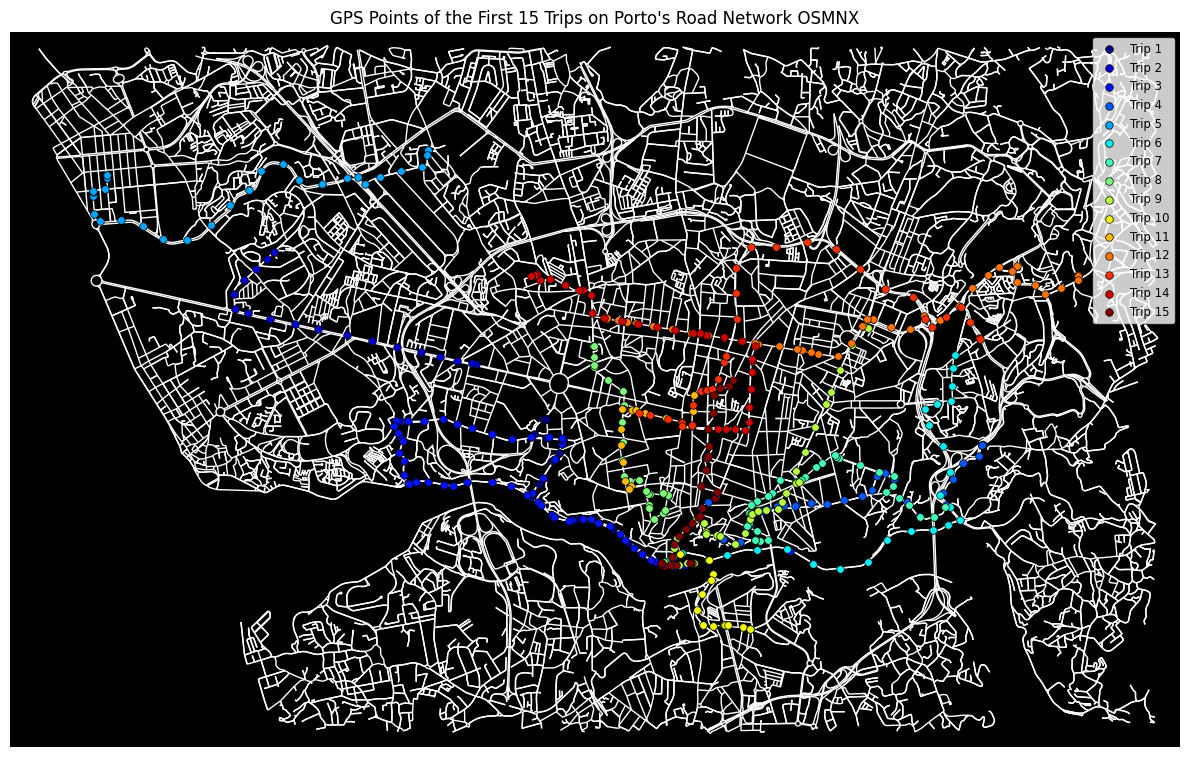

Image saved to data\GPS_Trajectories_First_15_Trips_OSMNX.png


In [ ]:
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(12,12), bgcolor='black', edge_color='white', node_color='black', node_size=0)
color_map = plt.cm.jet(np.linspace(0, 1, 15))
for i, trajectory in enumerate(trajectories[:15]):
    x_coords, y_coords = zip(*trajectory)
    ax.scatter(x_coords, y_coords, s=30, label=f'Trip {i+1}', color=color_map[i], edgecolor='k', linewidth=0.5)

ax.set_title("GPS Points of the First 15 Trips on Porto's Road Network OSMNX")
plt.legend(loc="upper right", fontsize='small')
plt.tight_layout()

output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'GPS_Trajectories_First_15_Trips_OSMNX.png')
plt.savefig(output_path, format='png', dpi=300)
plt.show()

print(f"Image saved to {output_path}")

In [ ]:
#'CartoDB positron' Folium Plot

# Initialize variables
trajectories = []
trajectory_count = 0
x_max = y_max = x_min = y_min = 0
is_first = True

df_15 = pd.read_csv('data/train-1500.csv', nrows=15)

# Process each polyline in the CSV
for polyline in df_15['POLYLINE']:
    # Remove the outer brackets
    polyline = polyline.strip()[2:-2]
    trajectory = []
    
    if len(polyline) <= 2:
        print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
    else:
        # Split the polyline into individual coordinate pairs
        for coordinate in polyline.split('],['):
            try:
                longitude, latitude = map(float, coordinate.strip().split(','))
                # Append as (latitude, longitude) for Folium
                trajectory.append((latitude, longitude))
                # Update boundaries
                x_max, y_max, x_min, y_min, is_first = calculate_boundaries(
                    x_max, y_max, x_min, y_min, is_first, longitude, latitude)
            except ValueError as e:
                print(f'Error parsing coordinate "{coordinate}": {e}')
    
    trajectories.append(trajectory)
    trajectory_count += 1

print(f'xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')

# Initialize the Folium map
f = folium.Figure(width=1500, height=1000)
map_center = [(y_min + y_max) / 2, (x_min + x_max) / 2]

# Create the Folium map with the specified tiles
tiles = 'CartoDB positron'  
m = folium.Map(location=map_center, zoom_start=14, tiles=tiles, zoom_control=False).add_to(f)
m.fit_bounds([[y_min, x_min], [y_max, x_max]])

# Generate a color map with 15 distinct colors
color_map = plt.cm.jet(np.linspace(0, 1, 15))  

# Disable plotting of lines
PLOT_LINES = False  

# Plot the first 15 trajectories on the Folium map
for i, trajectory in enumerate(trajectories[:15]):
    color = f'#{int(color_map[i][0]*255):02x}{int(color_map[i][1]*255):02x}{int(color_map[i][2]*255):02x}'
    if trajectory:
        # Create a feature group for each trip
        feature_group = folium.FeatureGroup(name=f'Trip {i+1}')
        for point in trajectory:
            folium.CircleMarker(
                location=point, 
                radius=5, 
                color=color, 
                fill=True, 
                fill_color=color, 
                fill_opacity=1
            ).add_to(feature_group)
    
        m.add_child(feature_group)

# Create a custom legend using HTML
legend_html = '''
<div style="
position: fixed; 
bottom: 50px; left: 50px; width: 150px; height: 300px; 
background-color: white; z-index:9999; font-size:14px;
border:2px solid grey;
overflow: auto;
">
    <p style="margin: 10px;"><b>Legend</b></p>
    <ul style="list-style: none; padding-left: 10px;">
'''

# Append each trip to the legend
for i in range(15):
    color_hex = f'#{int(color_map[i][0]*255):02x}{int(color_map[i][1]*255):02x}{int(color_map[i][2]*255):02x}'
    legend_html += f'<li><span style="background-color:{color_hex};width:20px;height:5px;display:inline-block;"></span> Trip {i+1}</li>'

legend_html += '''
    </ul>
</div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)
output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'GPS_Trajectories_First_15_Trips_Folium_1.html')

# Save the map to an HTML file
m.save(output_path)
print(f"Interactive map with legend saved to {output_path}")

xMin: -8.689086, yMin: 41.134158, xMax: -8.562348, yMax: 41.180517
Interactive map with legend saved to data\GPS_Trajectories_First_15_Trips_Folium_1.html


In [ ]:
#Rerun to plot Folium2

import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def calculate_boundaries(current_x_max, current_y_max, current_x_min, current_y_min, is_first, longitude, latitude):
    if is_first:
        current_x_min = current_x_max = longitude
        current_y_min = current_y_max = latitude
        is_first = False
    else:
        current_x_max = max(current_x_max, longitude)
        current_x_min = min(current_x_min, longitude)
        current_y_max = max(current_y_max, latitude)
        current_y_min = min(current_y_min, latitude)
    return current_x_max, current_y_max, current_x_min, current_y_min, is_first

trajectories = []
trajectory_count = 0
x_max = y_max = x_min = y_min = 0
is_first = True

df_15 = pd.read_csv('data/train-1500.csv', nrows=15)

for polyline in df_15['POLYLINE']:
    polyline = polyline.strip()[2:-2]
    trajectory = []
    
    if len(polyline) <= 2:
        print(f'Skip empty row {trajectory_count}: Length={len(polyline)}, Element={polyline}')
    else:
        for coordinate in polyline.split('],['):
            try:
                longitude, latitude = map(float, coordinate.strip().split(','))
                trajectory.append((latitude, longitude))
                x_max, y_max, x_min, y_min, is_first = calculate_boundaries(
                    x_max, y_max, x_min, y_min, is_first, longitude, latitude)
            except ValueError as e:
                print(f'Error parsing coordinate "{coordinate}": {e}')
    
    trajectories.append(trajectory)
    trajectory_count += 1

print(f'xMin: {x_min}, yMin: {y_min}, xMax: {x_max}, yMax: {y_max}')

# Initialize the Folium map
f = folium.Figure(width=1500, height=1000)

# Calculate the center of the map
map_center = [(y_min + y_max) / 2, (x_min + x_max) / 2]

m = folium.Map(location=map_center, zoom_start=14, zoom_control=False).add_to(f)
m.fit_bounds([[y_min, x_min], [y_max, x_max]])
# Generate a color map with 15 distinct colors
color_map = plt.cm.jet(np.linspace(0, 1, 15))  
PLOT_LINES = False  

# Plot the first 15 trajectories on the Folium map
for i, trajectory in enumerate(trajectories[:15]):
    color = f'#{int(color_map[i][0]*255):02x}{int(color_map[i][1]*255):02x}{int(color_map[i][2]*255):02x}'
    if trajectory:
        feature_group = folium.FeatureGroup(name=f'Trip {i+1}')
        for point in trajectory:
            folium.CircleMarker(
                location=point, 
                radius=5, 
                color=color, 
                fill=True, 
                fill_color=color, 
                fill_opacity=1
            ).add_to(feature_group)
    
        m.add_child(feature_group)

# Create a custom legend using HTML
legend_html = '''
<div style="
position: fixed; 
bottom: 50px; left: 50px; width: 150px; height: 300px; 
background-color: white; z-index:9999; font-size:14px;
border:2px solid grey;
overflow: auto;
">
    <p style="margin: 10px;"><b>Legend</b></p>
    <ul style="list-style: none; padding-left: 10px;">
'''

# Append each trip to the legend
for i in range(15):
    color_hex = f'#{int(color_map[i][0]*255):02x}{int(color_map[i][1]*255):02x}{int(color_map[i][2]*255):02x}'
    legend_html += f'<li><span style="background-color:{color_hex};width:20px;height:5px;display:inline-block;"></span> Trip {i+1}</li>'

legend_html += '''
    </ul>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)
output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, 'GPS_Trajectories_First_15_Trips_Folium2.html')
# Save the map to an HTML file
m.save(output_path)

print(f"Interactive map with legend saved to {output_path}")

xMin: -8.689086, yMin: 41.134158, xMax: -8.562348, yMax: 41.180517
Interactive map with legend saved to data\GPS_Trajectories_First_15_Trips_with_Legend.html
